In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1MB 33.2MB/s 
     |████████████████████████████████| 3.4MB 18.6MB/s 
     |████████████████████████████████| 25.3MB 119kB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [2]:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing import image
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import KerasClassifier
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from art.utils import to_categorical

import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-yo07my1t
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-yo07my1t
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp37-none-any.whl size=794840 sha256=933c6a3c2b97024c9805038a0d5b2b1b951559cbaa036e303bb757804bbffd5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-vfrjkd18/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


57344/56060 [==============================] - 0s 0us/step


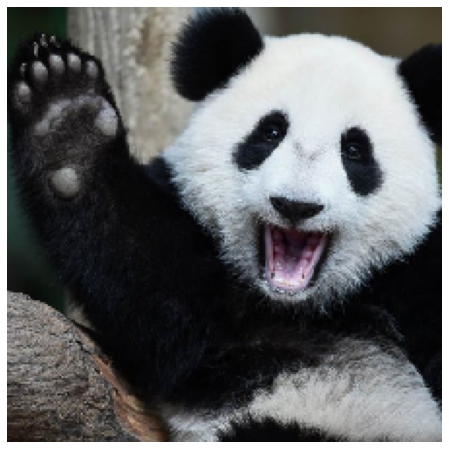

In [3]:
img_path = tf.keras.utils.get_file('Panda', origin= 'https://pbs.twimg.com/profile_images/829274786362699776/a1ttXfVG.jpg')

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.figure(figsize=(8,8)); plt.imshow(img); plt.axis('off'); plt.show()

In [4]:
model = DenseNet121(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
33193984/33188688 [==============================] - 0s 0us/step


In [5]:
x_check = np.expand_dims(x.copy(), axis=0)
x_check = preprocess_input(x_check)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x_check[0])
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]
print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 0.99


In [6]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1] 

preprocessor = ResNet50Preprocessor()

classifier = KerasClassifier(
    model=model,
    clip_values=(0, 255),
    preprocessing=preprocessor
)

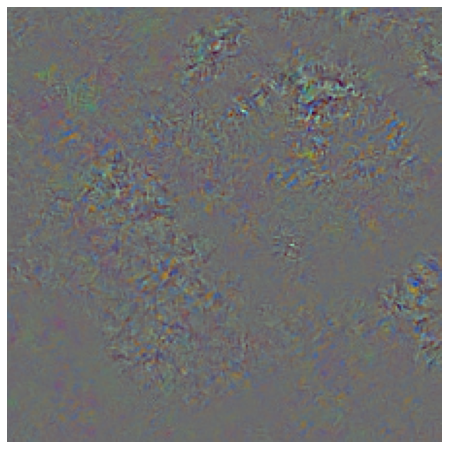

In [7]:
loss_gradient = classifier.loss_gradient(x=x, y=to_categorical([label], nb_classes=1000))

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient[0] 

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8)); plt.imshow(loss_gradient_plot); plt.axis('off'); plt.show()

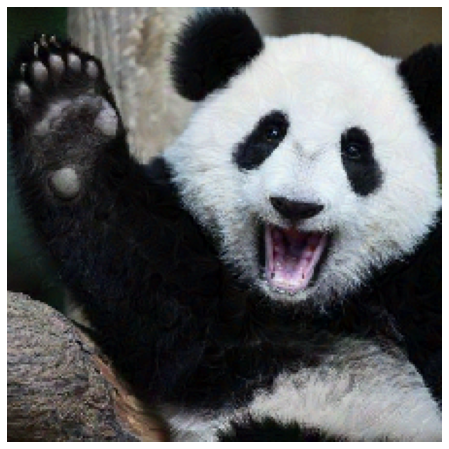

Prediction: black swan, Cygnus atratus - confidence 1.00


In [8]:
attack = ProjectedGradientDescent(estimator=classifier, targeted=True, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_test_adv = attack.generate(x=x, y=to_categorical([100]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_test_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_test_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

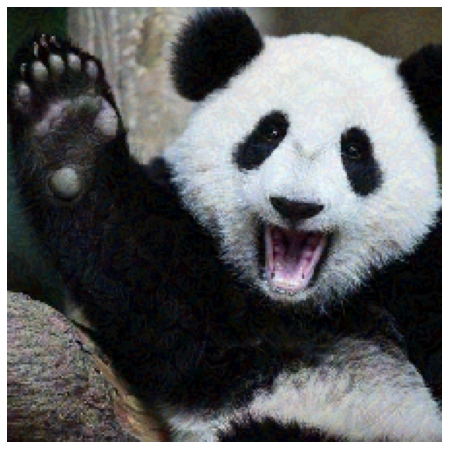

Prediction: teddy, teddy bear - confidence 0.43


In [9]:
attack = FastGradientMethod(estimator=classifier, targeted=True, eps_step=1, eps=5)

# Generate the adversarial sample:
x_test_adv = attack.generate(x=x, y=to_categorical([100]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_test_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_test_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))


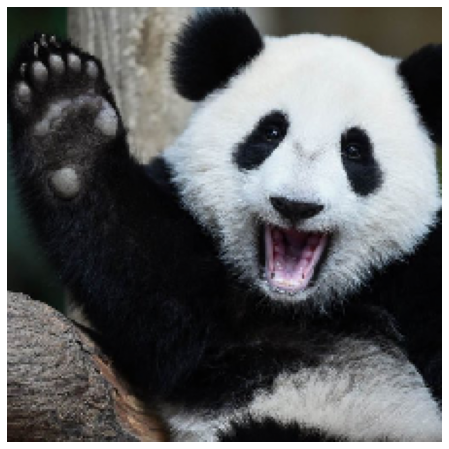

Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca - confidence 0.97


In [10]:
attack = DeepFool(classifier=classifier, max_iter=10, epsilon=5)

# Generate the adversarial sample:
x_test_adv = attack.generate(x=x)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_test_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_test_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))